In [47]:
import sys
import pandas as pd
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pypfopt
import yfinance as yf
from IPython.display import display
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.optimize import minimize
from typing import List, Tuple
from pymongo import MongoClient
from tqdm import tqdm

sys.path.append('..')

from pseudoFrameWork.api import getAnyMOEX

mongoClient = MongoClient('localhost', 27017, username='admin', password='admin')
db = mongoClient['rlab_db']

TODAY = dt.datetime.today()
DATE_FORMAT = '%Y-%m-%d'
DATA_LOAD_LIMIT = 100

db.list_collection_names()

['q1.CBGoldQuotes',
 'q1.futuresQuotes',
 'q1.RGBIQuotes',
 'q2.YahooFinanceETFMarketData',
 'q1.MREDCQuotes',
 'futuresList',
 'q1.GLDRUB_TOMQuotes',
 'q1.RUCBTRNSQuotes',
 'q1.futuresQuotesContinuous',
 'q2.futuresQuotes',
 'q1.IMOEXQuotes']

In [2]:
def insertToDB(name, data, dataBase): dataBase[name].insert_many([data.iloc[i].to_dict() for i in range(data.shape[0])])


#### Question 1
Diversification of portfolio by Futures

Period = (2019-12-01, 2025-09-30)

Basic Portfolio:
- Gold
- IMOEX
- RGBI
- IFX (или RUCBTRNS?)
- MREDC

Futures:
Si, Eu, BR, RUON, SUGR

In [3]:
PERIOD = (dt.datetime(2019, 12, 1), dt.datetime(2025, 9, 30))

## Gold

# goldCB = pd.read_html('https://www.cbr.ru/hd_base/metall/metall_base_new/?UniDbQuery.Posted=True&UniDbQuery.From=01.12.2019&UniDbQuery.To=30.09.2025&UniDbQuery.Gold=true&UniDbQuery.so=1')
# goldCB = goldCB[0]
# goldCB.columns = ['date', 'price']
# goldCB['date'] = pd.to_datetime(goldCB['date'], dayfirst=True)
# goldCB['price'] = goldCB['price'].str.replace(',', '.', regex=True).replace(' ', '', regex=True).astype(float)
# insertToDB('q1.CBGoldQuotes', goldCB, db)

## IMOEX, RGBI, RUCBTRNS

# MOEXIndex = ('RUCBTRNS')
# MOEXIndex = ('IMOEX', 'RGBI', 'RUCBTRNS')

# for idx in tqdm(MOEXIndex):
#     numPeriods = math.ceil((PERIOD[1] - PERIOD[0]).days / DATA_LOAD_LIMIT)
#     periods = [(PERIOD[0] + pd.offsets.Day(DATA_LOAD_LIMIT * period)).strftime(DATE_FORMAT) for period in range(numPeriods)]
#     periods.append(PERIOD[1].strftime(DATE_FORMAT))

#     for j in range(len(periods) - 1):
#         loopData = await getAnyMOEX(
#             api_method=rf'/iss/history/engines/stock/markets/index/sessions/total/securities/{idx}.json',
#             arguments={'from': periods[j], 'till': periods[j+1]},
#             field='history'
#         )

#         insertToDB(f'q1.{idx}Quotes', loopData, db)

## GLDRUB_TOM

# numPeriods = math.ceil((PERIOD[1] - PERIOD[0]).days / DATA_LOAD_LIMIT)
# periods = [(PERIOD[0] + pd.offsets.Day(DATA_LOAD_LIMIT * period)).strftime(DATE_FORMAT) for period in range(numPeriods)]
# periods.append(PERIOD[1].strftime(DATE_FORMAT))

# for j in range(len(periods) - 1):
#     loopData = await getAnyMOEX(
#         api_method=r'/iss/history/engines/currency/markets/selt/sessions/CETS/securities/GLDRUB_TOM.json',
#         arguments={'from': periods[j], 'till': periods[j+1]},
#         field='history'
#     )

#     loopData = loopData[loopData['BOARDID'] == 'CETS'] 

#     insertToDB(f'q1.GLDRUB_TOMQuotes', loopData, db)

## MREDC

# numPeriods = math.ceil((PERIOD[1] - PERIOD[0]).days / DATA_LOAD_LIMIT)
# periods = [(PERIOD[0] + pd.offsets.Day(DATA_LOAD_LIMIT * period)).strftime(DATE_FORMAT) for period in range(numPeriods)]
# periods.append(PERIOD[1].strftime(DATE_FORMAT))

# for j in range(len(periods) - 1):
#     loopData = await getAnyMOEX(
#         api_method=r'/iss/history/engines/stock/markets/index/sessions/RTSI/securities/MREDC.json',
#         arguments={'from': periods[j], 'till': periods[j+1]},
#         field='history'
#     )

#     insertToDB(f'q1.MREDCQuotes', loopData, db)



## Futures (BR, Si, Eu, SUGR, RUON)

# futuresQ1 = (
#     'BRZ0', 'BRZ1', 'BRZ2', 'BRZ3', 'BRZ4', 'BRZ5',
#     'SiU1', 'SiM2', 'SiM4', 'SiM6',
#     'EuH1', 'EuM2', 'EuZ3', 'EuM5', 'EuZ6',
#     'SAH0', 'SAK0', 'SAV0', 'SAK1', 'SAV1', 'SAK2', 'SAV2', 'SAH3SAK3', 'SAN3', 'SAH4', 'SAN4', 'SAH5', 'SAN5', 'SAH6',
#     'RRX0', 'RRV1', 'RRU2', 'RRJ3', 'RRH4', 'RRG5', 'RRF6'
# )

# futuresList = pd.DataFrame(db['futuresList'].find())

# for ticker in tqdm(futuresQ1):
#     info = futuresList[futuresList['secid'] == ticker]

#     numPeriods = math.ceil(
#         (dt.datetime.strptime(info.iloc[0].expiration_date, DATE_FORMAT) - dt.datetime.strptime(info.iloc[0].start_date, DATE_FORMAT)).days / DATA_LOAD_LIMIT
#     )

#     periods = [
#         (dt.datetime.strptime(info.iloc[0].start_date, DATE_FORMAT) + pd.offsets.Day(DATA_LOAD_LIMIT * period)).strftime(DATE_FORMAT) for period in range(numPeriods)
#     ]
    
#     periods.append(info.iloc[0].expiration_date)

#     for j in range(len(periods) - 1):
#         loopData = await getAnyMOEX(
#             api_method=rf'/iss/history/engines/futures/markets/forts/boards/rfud/securities/{ticker}.json',
#             arguments={'from': periods[j], 'till': periods[j+1]},
#             field='history'
#         )

#         if loopData.empty: continue

#         else: db['q1.futuresQuotes'].insert_many([loopData.iloc[row].to_dict() for row in range(loopData.shape[0])])

# futuresQuotes = pd.DataFrame(db['q1.futuresQuotes'].find())

# mappingTickers = {
#     'BR': 'BR',
#     'Si': 'Si',
#     'Eu': 'Eu',
#     'SUGR': 'SA',
#     'RUON': 'RR',
# }

# for futures in ('BR', 'Si', 'Eu', 'SUGR', 'RUON'):
#     futuresQuotesContinuous = futuresQuotes[futuresQuotes['SECID'].str.contains(mappingTickers.get(futures))]['TRADEDATE'].sort_values()
#     futuresQuotesContinuous = futuresQuotesContinuous.to_frame()

#     for ticker in futuresQuotes[futuresQuotes['SECID'].str.contains(mappingTickers.get(futures))]['SECID'].unique():
#         futuresQuotesContinuous = futuresQuotesContinuous.merge(
#             futuresQuotes[futuresQuotes['SECID'] == ticker][['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': ticker}),
#             on='TRADEDATE',
#             how='left'
#         )

#     futuresQuotesContinuous['price'] = np.nan
#     columns = futuresQuotesContinuous.columns.tolist()
#     columns.remove('TRADEDATE')

#     for col in columns:
#         futuresQuotesContinuous['price'] = futuresQuotesContinuous['price'].combine_first(futuresQuotesContinuous[col])
    
#     futuresQuotesContinuous['ticker'] = futures    
    
#     insertToDB('q1.futuresQuotesContinuous', futuresQuotesContinuous[['ticker', 'TRADEDATE', 'price']], db)

futuresQuotes = pd.DataFrame(db['q1.futuresQuotesContinuous'].find())

Si = futuresQuotes[futuresQuotes['ticker'] == 'Si'][['TRADEDATE', 'price']].rename(columns={'price': 'Si'})
Si['Si'] = Si['Si'].bfill()

Eu = futuresQuotes[futuresQuotes['ticker'] == 'Eu'][['TRADEDATE', 'price']].rename(columns={'price': 'Eu'})
Eu['Eu'] = Eu['Eu'].bfill()

BR = futuresQuotes[futuresQuotes['ticker'] == 'BR'][['TRADEDATE', 'price']].rename(columns={'price': 'BR'})
BR['BR'] = BR['BR'].bfill()

# Gold = pd.DataFrame(db['q1.CBGoldQuotes'].find()).astype({'date': str})[['date', 'price']].rename(columns={'date': 'TRADEDATE', 'price': 'Gold'})

Gold = pd.DataFrame(db['q1.GLDRUB_TOMQuotes'].find())
Gold.loc[Gold['CLOSE'] == 0] = np.nan
Gold['CLOSE'] = Gold['CLOSE'].bfill()
Gold = Gold[['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': 'Gold'})

IMOEX = pd.DataFrame(db['q1.IMOEXQuotes'].find())[['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': 'IMOEX'})
MREDC = pd.DataFrame(db['q1.MREDCQuotes'].find())[['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': 'MREDC'})
RGBI = pd.DataFrame(db['q1.RGBIQuotes'].find())[['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': 'RGBI'})
RUCBTRNS = pd.DataFrame(db['q1.RUCBTRNSQuotes'].find())[['TRADEDATE', 'CLOSE']].rename(columns={'CLOSE': 'RUCBTRNS'})

IFX = pd.read_excel('IFX.xlsx')
IFX['Дата'] = IFX['Дата'].dt.strftime('%Y-%m-%d')
IFX = IFX[['Дата', 'IFX-Cbonds PI']].rename(columns={'IFX-Cbonds PI': 'IFX', 'Дата': 'TRADEDATE'})

data = Si.merge(Eu, on='TRADEDATE', how='left')
data = data.merge(BR, on='TRADEDATE', how='left')
data = data.merge(Gold, on='TRADEDATE', how='left')
data = data.merge(IMOEX, on='TRADEDATE', how='left')
# data = data.merge(IFX, on='TRADEDATE', how='left')
# data = data.merge(RGBI, on='TRADEDATE', how='left')
data = data.merge(MREDC, on='TRADEDATE', how='left')
# data = data.merge(RUCBTRNS, on='TRADEDATE', how='left')
data.drop_duplicates(inplace=True)

data = data[(pd.to_datetime(data['TRADEDATE']) >= PERIOD[0]) & (pd.to_datetime(data['TRADEDATE']) <= PERIOD[1])]
data = data.bfill()
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# data['RGBI'] = 1000 * np.cumprod(np.power(data['RGBI'] / 100 + 1, 1/252))
# data['IFX'] = 1000 * np.cumprod(np.power(data['IFX'] / 10000 + 1, 1/252))
# data['IFX'] = data['IFX'] / data.loc[0, 'IFX'] * 1000
# data['RGBI'] = data['RGBI'] / data.loc[0, 'RGBI'] * 1000

# data['Gold'] = data['Gold'] / 1000

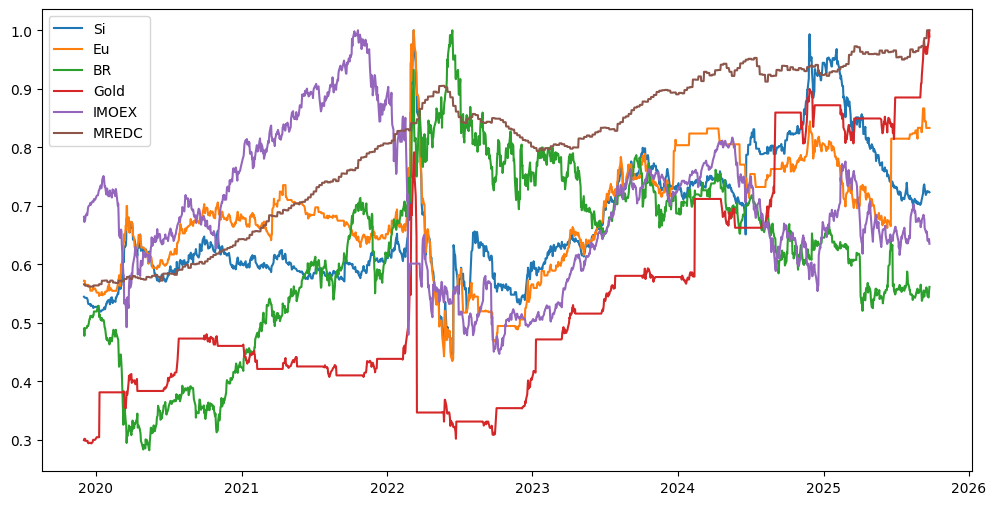

In [4]:
plt.figure(figsize=(12, 6))

vizual = data.copy()

cols = vizual.columns.to_list()
cols.remove('TRADEDATE')

for col in cols: 
    vizual[col] = vizual[col] / vizual[col].max()

    plt.plot(pd.to_datetime(vizual['TRADEDATE']), vizual[col], label=col)

plt.legend()
plt.show()


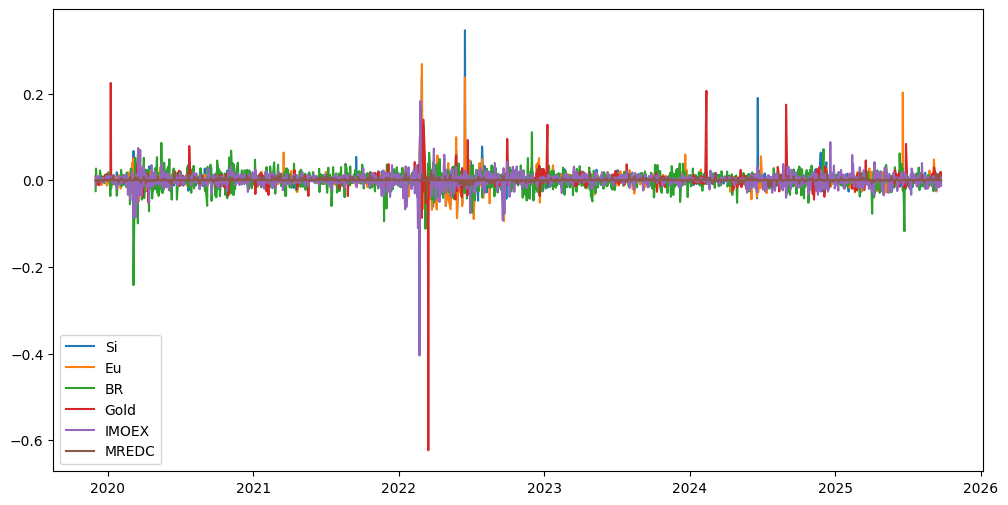

In [5]:
plt.figure(figsize=(12, 6))

vizual = data.copy()

cols = vizual.columns.to_list()
cols.remove('TRADEDATE')

for col in cols: 
    plt.plot(pd.to_datetime(vizual['TRADEDATE'])[:-1], np.diff(np.log(vizual[col])), label=col)

plt.legend()
plt.show()


In [6]:
corr = pd.DataFrame()

for col in cols:
    corr[col] = np.diff(np.log(data[col]))

corr.corr().style.background_gradient(cmap='coolwarm')

,Si,Eu,BR,Gold,IMOEX,MREDC
Si,1.000000,0.687861,-0.022060,0.133870,-0.134969,-0.024192
Eu,0.687861,1.000000,-0.017575,0.129268,-0.077417,-0.022281
BR,-0.022060,-0.017575,1.000000,0.017283,0.153484,-0.011029
Gold,0.133870,0.129268,0.017283,1.000000,-0.033881,-0.028662
IMOEX,-0.134969,-0.077417,0.153484,-0.033881,1.000000,0.001659
MREDC,-0.024192,-0.022281,-0.011029,-0.028662,0.001659,1.000000


In [7]:
data[cols].corr().style.background_gradient(cmap='coolwarm')

,Si,Eu,BR,Gold,IMOEX,MREDC
Si,1.000000,0.765101,0.119926,0.848086,-0.029106,0.647703
Eu,0.765101,1.000000,-0.080594,0.752561,0.352356,0.440894
BR,0.119926,-0.080594,1.000000,0.007314,-0.241437,0.668882
Gold,0.848086,0.752561,0.007314,1.000000,0.015302,0.685323
IMOEX,-0.029106,0.352356,-0.241437,0.015302,1.000000,-0.142316
MREDC,0.647703,0.440894,0.668882,0.685323,-0.142316,1.000000


In [8]:
class MarkowitzStats(object):

    def __init__(self, data: pd.DataFrame | None = None, riskFree: float = 0.09827) -> None:
        self.DAYS_IN_YEAR = 252

        self.ER = None
        self.std = None
        self.Cov = None
        self.assets = None
        self.maxSharpe = None
        self.weights = None
        self.riskFree = riskFree

        if data is not None: self.updateData(data, riskFree)
    

    def getStats(self, zeroRiskAversion: bool = False): return self.riskAversion(zeroRiskAversion=zeroRiskAversion)
    

    def riskAversion(self, A: Tuple[float] = (1, 2, 3, 4), zeroRiskAversion: bool = False) -> pd.DataFrame:
        riskAversionStats = pd.DataFrame(
            columns=self.assets + ['RGBI', 'Exp Utility', 'Exp Return', 'SD', 'Sharpe Ratio'],
            index=[f'A={a}' for a in A]
        )

        if zeroRiskAversion:
            riskAversionStats.loc['A=0', :] = self.optimalWieghts.tolist() + [
                0,
                self.optimalWieghts @ self.ER.T,
                self.optimalWieghts @ self.ER.T,
                np.sqrt(self.optimalWieghts @ self.Cov @ self.optimalWieghts.T),
                self.maxSharpe
            ]

        for i, a in enumerate(A):
            y = (self.optimalWieghts @ self.ER.T - self.riskFree) / (a * self.optimalWieghts @ self.Cov @ self.optimalWieghts.T)
            newWeights = self.optimalWieghts.copy() * y
            
            EU = newWeights @ self.ER.T - 0.5 * a * newWeights @ self.Cov @ newWeights.T
            ExpReturn = y * newWeights @ self.ER.T + (1 - y) * self.riskFree
            SD = np.sqrt(newWeights @ self.Cov @ newWeights.T)

            Sharpe = ExpReturn / SD

            riskAversionStats.iloc[i] = newWeights.tolist() + [1 - y, EU, ExpReturn, SD, Sharpe]
        
        riskAversionStats = riskAversionStats.sort_index().astype(float).round(4)
        display(riskAversionStats)
        
        return riskAversionStats


    @property
    def optimalWieghts(self) -> np.ndarray:
        if self.weights is None:
            Y = np.linspace(0.01, 10, 1000)
            weights = np.vectorize(self.__estimateOptimalWeights, otypes=[np.ndarray])(Y)

            Stdp = np.array([np.sqrt(w @ self.Cov @ w.T) for w in weights])
            ERp = np.array([w @ self.ER.T for w in weights])

            Sharpe = ERp / Stdp
            self.maxSharpe = Sharpe.max()

            print(f'Optimal Weights: {[round(w.item(), 4) * 100 for w in weights[np.argmax(Sharpe)]]}\nMax Sharpe Ratio: {round(self.maxSharpe, 4)}')

            plt.plot(Stdp, ERp, color='blue', label='Efficient Frontier')
            plt.plot(Stdp[np.argmax(Sharpe)], ERp[np.argmax(Sharpe)], marker='o', color='red', label='Max Sharpe Ratio')

            plt.legend()
            plt.show()

            self.weights = weights[np.argmax(Sharpe)]
        
        return self.weights
    

    def __estimateOptimalWeights(self, Y: float = 1.0) -> np.ndarray:
        objective = lambda w: w @ self.Cov @ w.T - Y * w @ self.ER.T
        sumEqualOne = lambda w: w.sum() - 1

        constraints = (
            {'type': 'eq', 'fun': sumEqualOne},
        )

        initialGuess = np.ones(self.std.shape[0]) / self.std.shape[0]
        bounds = tuple((0, 1) for _ in range(self.std.shape[0]))

        result = minimize(
            fun=objective,
            x0=initialGuess,
            method='SLSQP',  # Sequential Least Squares Programming
            bounds=bounds,
            constraints=constraints,
            options={'ftol': 1e-9, 'disp': False}
        )

        return result.x

    
    def updateData(self, data: pd.DataFrame) -> None:
        self.assets = data.columns.to_list()
        
        print(f'New Portfolio ({len(self.assets)} assets): {self.assets}')

        estimatedReturns = {
            'Si':	0.15438219776340045,
            'Eu':	0.14915303412209727,
            'BR':	0.12227672834475432,
            'Gold':	0.13800974856544662,
            'IMOEX': 0.07654550470927111,
            'MREDC': 0.0011679255083976887,
        }

        ER = np.array([estimatedReturns.get(asset) for asset in self.assets])
        std = np.diff(np.log(data), axis=0).std(axis=0) * np.sqrt(self.DAYS_IN_YEAR)
        Corr = np.corrcoef(data.T)

        print(f'ER: {[round(Er.item(), 4) * 100 for Er in ER]}\nStd: {[round(vola.item(), 4) * 100 for vola in std]}')

        Cov = np.ones_like(Corr)

        for i in range(std.shape[0]):
            for j in range(std.shape[0]):
                Cov[i, j] = Corr[i, j] * std[i] * std[j]
        
        self.ER, self.std, self.Cov, self.weights = ER, std, Cov, None



New Portfolio (6 assets): ['Si', 'Eu', 'BR', 'Gold', 'IMOEX', 'MREDC']
ER: [15.440000000000001, 14.92, 12.23, 13.8, 7.6499999999999995, 0.12]
Std: [27.61, 26.83, 32.28, 36.19, 29.770000000000003, 4.62]
Optimal Weights: [28.610000000000003, 19.07, 30.09, 0.0, 22.220000000000002, 0.0]
Max Sharpe Ratio: 0.744


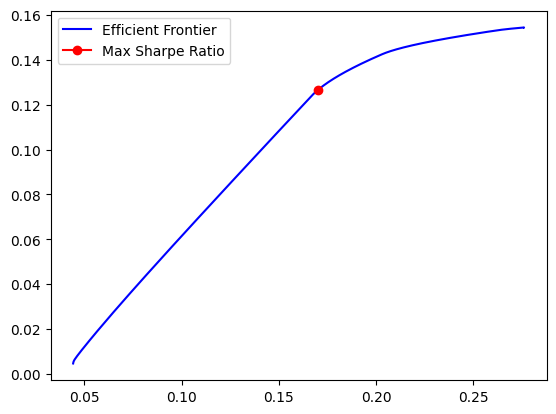

,Si,Eu,BR,Gold,IMOEX,MREDC,RGBI,Exp Utility,Exp Return,SD,Sharpe Ratio
A=0,0.2861,0.1907,0.3009,0.0,0.2222,0.0,0.0000,0.1264,0.1264,0.1699,0.7440
A=1,0.2790,0.1860,0.2934,0.0,0.2167,0.0,0.0250,0.1095,0.1226,0.1657,0.7402
A=2,0.1395,0.0930,0.1467,0.0,0.1083,0.0,0.5125,0.0548,0.0804,0.0828,0.9706
A=3,0.0930,0.0620,0.0978,0.0,0.0722,0.0,0.6750,0.0365,0.0797,0.0552,1.4428
A=4,0.0697,0.0465,0.0733,0.0,0.0542,0.0,0.7562,0.0274,0.0818,0.0414,1.9755


New Portfolio (3 assets): ['Gold', 'IMOEX', 'MREDC']
ER: [13.8, 7.6499999999999995, 0.12]
Std: [36.19, 29.770000000000003, 4.62]
Optimal Weights: [55.279999999999994, 44.72, 0.0]
Max Sharpe Ratio: 0.4567


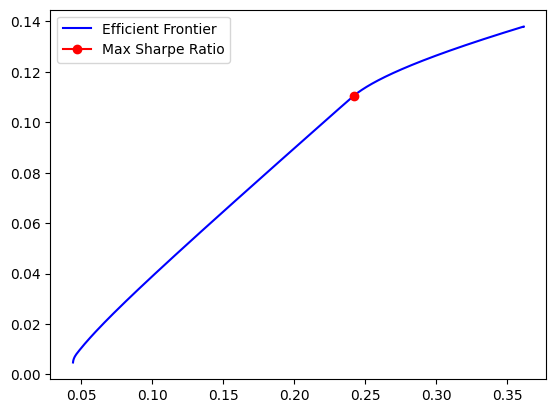

,Gold,IMOEX,MREDC,RGBI,Exp Utility,Exp Return,SD,Sharpe Ratio
A=0,0.5528,0.4472,0.0,0.0000,0.1105,0.1105,0.2420,0.4567
A=1,0.1157,0.0936,0.0,0.7908,0.0218,0.0825,0.0506,1.6302
A=2,0.0578,0.0468,0.0,0.8954,0.0109,0.0892,0.0253,3.5232
A=3,0.0386,0.0312,0.0,0.9303,0.0073,0.0920,0.0169,5.4480
A=4,0.0289,0.0234,0.0,0.9477,0.0055,0.0934,0.0127,7.3808


In [9]:
Assets = (
    ['Si', 'Eu', 'BR', 'Gold', 'IMOEX', 'MREDC'],
    ['Gold', 'IMOEX', 'MREDC'],
)

optimizer = MarkowitzStats()

for columns in Assets:
    optimizer.updateData(data[columns])
    optimizer.getStats(True)

In [10]:
0.744 / 0.4567

1.6290781694766805

#### Question 2

Futures - https://www.moex.com/s3810

In [28]:
df = pd.DataFrame(db['futuresList'].find())

etfFutures = pd.read_excel('ETFFutures.xlsx').dropna()
etfFutures.rename(columns={'Наименование': 'name', 'Код': 'code', 'Базовый актив': 'underlying', 'Лот': 'lot'}, inplace=True)
etfFutures['code'] = etfFutures['code'].str.replace(' ', '', regex=True)
etfFutures['code'] = etfFutures['code'].str.slice(0, -4)
etfFutures['lot'] = etfFutures['lot'].str.extract('(\d+)').astype('float')

underlyingMapping = {
    'SPYF': 'SPY',
    'NASD': 'QQQ',
    'STOX': 'EUN2.DE',
    'DAX': 'EXS1.DE',
    'NIKK': '1329.T',
    'DJ30': 'DIA',
    # 'R2000': 'IWM',
    # 'EM': 'EEM',          No Liquid
    # 'INDIA': 'NDIAA.XD',
    # 'SOXQ': 'SOXQ.MX',    No Data Yahoo
    # 'TENCENT': '0700.HK',
    # 'TLT': 'TLT',         
    # 'XIA': '1810.HK',     Too young Futures 
}

# etfMD = yf.Tickers(' '.join(list(underlyingMapping.values())))
# yahooData = etfMD.download(start=dt.datetime(2020, 1, 1), end=dt.datetime(2025, 9, 30), interval='1d', period=None)
# yahooData = yahooData.Close
# yahooData.reset_index(inplace=True)

# insertToDB('q2.YahooFinanceETFMarketData', yahooData, db)

yahooData = pd.DataFrame(db['q2.YahooFinanceETFMarketData'].find())

# plt.figure(figsize=(15, 7))

# for col in yahooData.drop(['_id', 'Date'], axis=1).columns:
#     plt.plot(yahooData['Date'], yahooData[col] / yahooData[col].max(), label=col)

# plt.title('Yahoo Finance MD')
# plt.legend()
# plt.show()

etfFuturesList = pd.DataFrame()

for code in underlyingMapping.keys():
    loop = df[df['name'].str.contains(code)].copy()
    loop['code'] = code

    etfFuturesList = pd.concat([etfFuturesList, loop], ignore_index=True)

etfFuturesList['underlyingYahoo'] = etfFuturesList['code'].apply(lambda x: underlyingMapping.get(x))
etfFuturesList = etfFuturesList.merge(etfFutures[['code', 'lot']], on='code')
etfFuturesList.drop(etfFuturesList[(etfFuturesList['asset_code'] != 'EM') & (etfFuturesList['code'] == 'EM')].index, inplace=True)
etfFuturesList.reset_index(drop=True, inplace=True)

# for ticker in tqdm(etfFuturesList['secid']):
#     info = etfFuturesList[etfFuturesList['secid'] == ticker]

#     numPeriods = math.ceil(
#         (dt.datetime.strptime(info.iloc[0].expiration_date, DATE_FORMAT) - dt.datetime.strptime(info.iloc[0].start_date, DATE_FORMAT)).days / DATA_LOAD_LIMIT
#     )

#     periods = [
#         (dt.datetime.strptime(info.iloc[0].start_date, DATE_FORMAT) + pd.offsets.Day(DATA_LOAD_LIMIT * period)).strftime(DATE_FORMAT) for period in range(numPeriods)
#     ]
    
#     periods.append(info.iloc[0].expiration_date)

#     for j in range(len(periods) - 1):
#         loopData = await getAnyMOEX(
#             api_method=rf'/iss/history/engines/futures/markets/forts/boards/rfud/securities/{ticker}.json',
#             arguments={'from': periods[j], 'till': periods[j+1]},
#             field='history'
#         )

#         if loopData.empty: continue

#         else: db['q2.futuresQuotes'].insert_many([loopData.iloc[row].to_dict() for row in range(loopData.shape[0])])

# futuresQuotes = pd.DataFrame(db['q2.futuresQuotes'].find())

futuresQuotes = pd.DataFrame(db['q2.futuresQuotes'].find())
futuresQuotes = futuresQuotes.merge(etfFuturesList[['secid', 'code', 'underlyingYahoo', 'lot']], left_on='SECID', right_on='secid')

futuresQuotesContinuous = pd.DataFrame()

for code in futuresQuotes['code'].unique():
    loopData = futuresQuotes[futuresQuotes['code'] == code].copy()
    loopData['CLOSEwLOT'] = loopData['CLOSE'] / loopData['lot']
    loopData.sort_values(by='TRADEDATE', inplace=True)
    
    quotes = pd.DataFrame(loopData['TRADEDATE'].unique(), columns=['TRADEDATE'])
    quotes['code'] = code
    quotes['under'] = loopData['underlyingYahoo'].unique()[0]

    for fort in loopData['SECID'].unique():
        quotes = quotes.merge(
            loopData[loopData['SECID'] == fort][['TRADEDATE', 'CLOSEwLOT']].rename(columns={'CLOSEwLOT': fort}),
            on='TRADEDATE',
            how='left'
        )
    
    quotes['futuresPrice'] = np.nan

    for fort in quotes.drop(['TRADEDATE', 'code', 'under'], axis=1).columns:
        quotes['futuresPrice'] = quotes['futuresPrice'].combine_first(quotes[fort])
    
    quotes = quotes[['TRADEDATE', 'code', 'under', 'futuresPrice']]
    quotes['futuresPrice'] = quotes['futuresPrice'].bfill()

    futuresQuotesContinuous = pd.concat([futuresQuotesContinuous, quotes], ignore_index=True)

data = pd.DataFrame()

for under in futuresQuotesContinuous['under'].unique():
    yahooLoop = yahooData[['Date', under]].copy()
    futuresQuotesLoop = futuresQuotesContinuous[futuresQuotesContinuous['under'] == under].copy()
    yahooLoop['Date'] = yahooLoop['Date'].dt.strftime('%Y-%m-%d')
    
    dataLoop = futuresQuotesLoop.merge(
        yahooLoop.rename(columns={under: 'underPrice'}),
        left_on='TRADEDATE',
        right_on='Date',
    )

    dataLoop.drop('Date', axis=1, inplace=True)
    dataLoop.sort_values(by='TRADEDATE', inplace=True)
    dataLoop['underPrice'] = dataLoop['underPrice'].bfill()

    data = pd.concat([data, dataLoop], ignore_index=True)

data.loc[data['code'] == 'NIKK', 'futuresPrice'] = data.loc[data['code'] == 'NIKK', 'futuresPrice'] / 10 # HardCode

etfFuturesList[['code', 'start_date']].groupby('code').min().sort_values(by='start_date').reset_index()



,code,start_date
0,SPYF,2021-05-25
1,NASD,2022-09-06
2,STOX,2022-11-29
3,DAX,2023-02-07
4,NIKK,2023-03-28
5,DJ30,2024-03-26


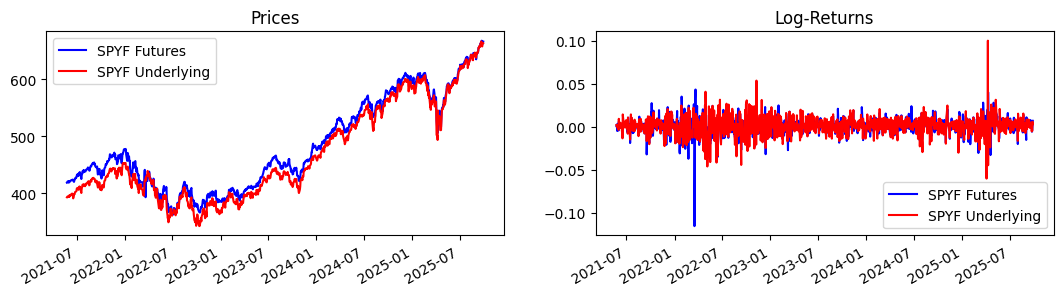

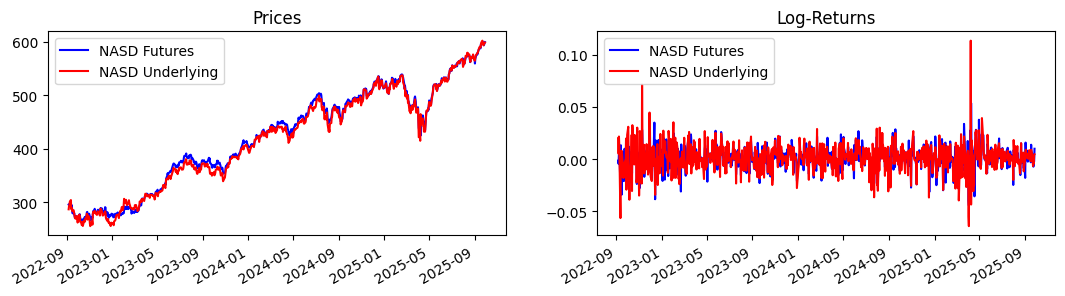

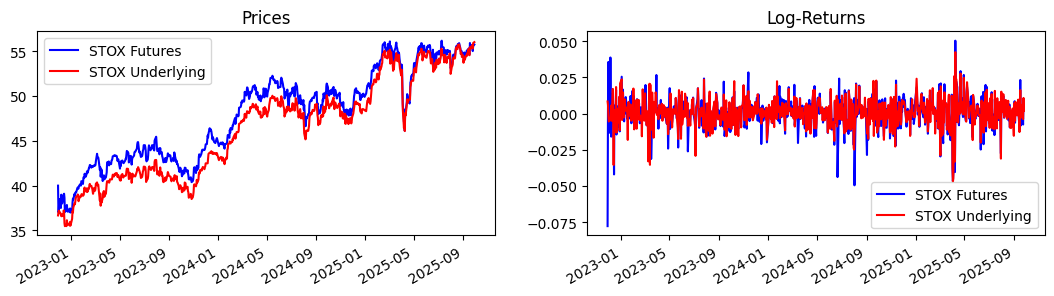

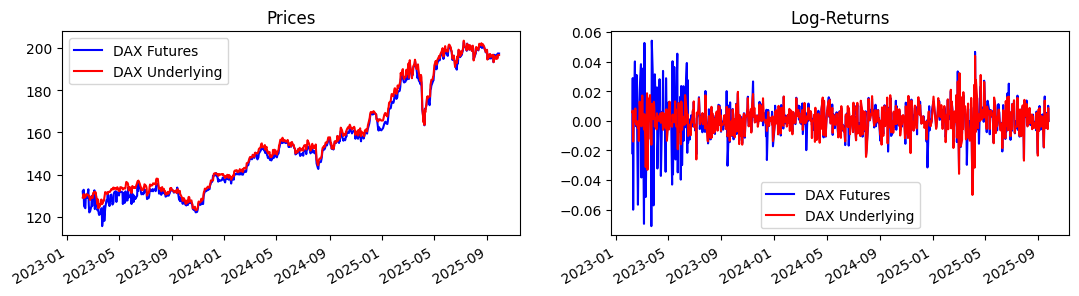

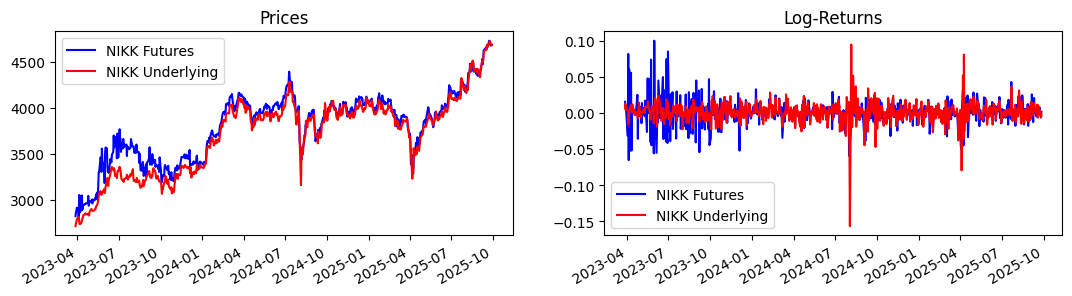

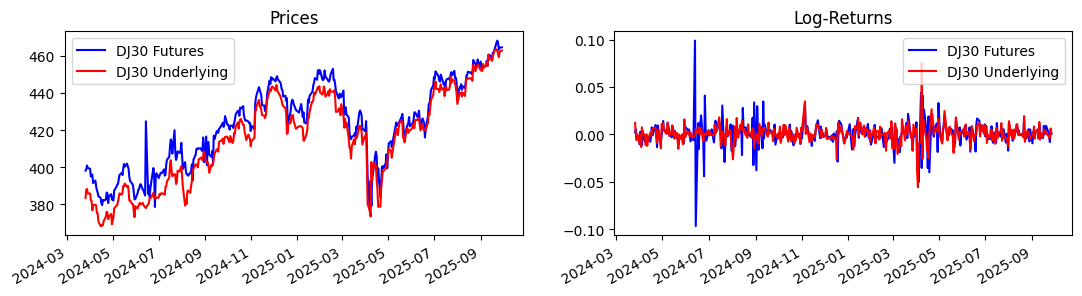

In [43]:

for code in data['code'].unique():
    loopData = data[data['code'] == code].copy()
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 3))

    ax[0].plot(pd.to_datetime(loopData['TRADEDATE']), loopData['futuresPrice'], label=f'{code} Futures', color='blue')
    ax[0].plot(pd.to_datetime(loopData['TRADEDATE']), loopData['underPrice'], label=f'{code} Underlying', color='red')
    ax[0].legend()
    ax[0].set_title('Prices')
        
    ax[1].plot(pd.to_datetime(loopData['TRADEDATE'][:-1]), np.diff(np.log(loopData['futuresPrice'])), label=f'{code} Futures', color='blue')
    ax[1].plot(pd.to_datetime(loopData['TRADEDATE'][:-1]), np.diff(np.log(loopData['underPrice'])), label=f'{code} Underlying', color='red')
    ax[1].legend()
    ax[1].set_title('Log-Returns')

    fig.autofmt_xdate()

    plt.show()

In [46]:
dataSelect = data[data['code'] == 'NIKK'].copy()

F = np.diff(np.log(dataSelect['futuresPrice']))
S = np.diff(np.log(dataSelect['underPrice']))


np.corrcoef(F, S)

array([[1.        , 0.36662255],
       [0.36662255, 1.        ]])